# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---


---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the train images to create the train and validation data loaders, and use the test images to create the test data loader.


All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
# Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import numpy as np
import torch

from torchvision import datasets 
import torchvision.transforms as transforms 
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load 
batch_size = 20

# percentage of training set to use as validation
valid_size = 0.2

img_size = 64

# convert data to a normalized torch.FloatTensor
transform = {'train' : transforms.Compose([
            transforms.RandomHorizontalFlip(), # randomly flip and rotate
            transforms.RandomRotation(10),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), 
            'test': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}



# choose the training and test datasets
train_data = datasets.ImageFolder('/data/landmark_images/train/', transform = transform['train'])
test_data = datasets.ImageFolder('/data/landmark_images/test/', transform = transform['test'])

#obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

#define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


#prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                           num_workers = num_workers)


loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

# specify the image classes
classes = [x.split('.')[1] for x in train_data.classes]


Images are all resized to 46 by 64. The tensor size is 64 * 64 * 3. 64 is for the image height and width and 3 is for the depth which is 3 because images are RGB.
I have augmented the dataset by horizontal flips and rotation.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

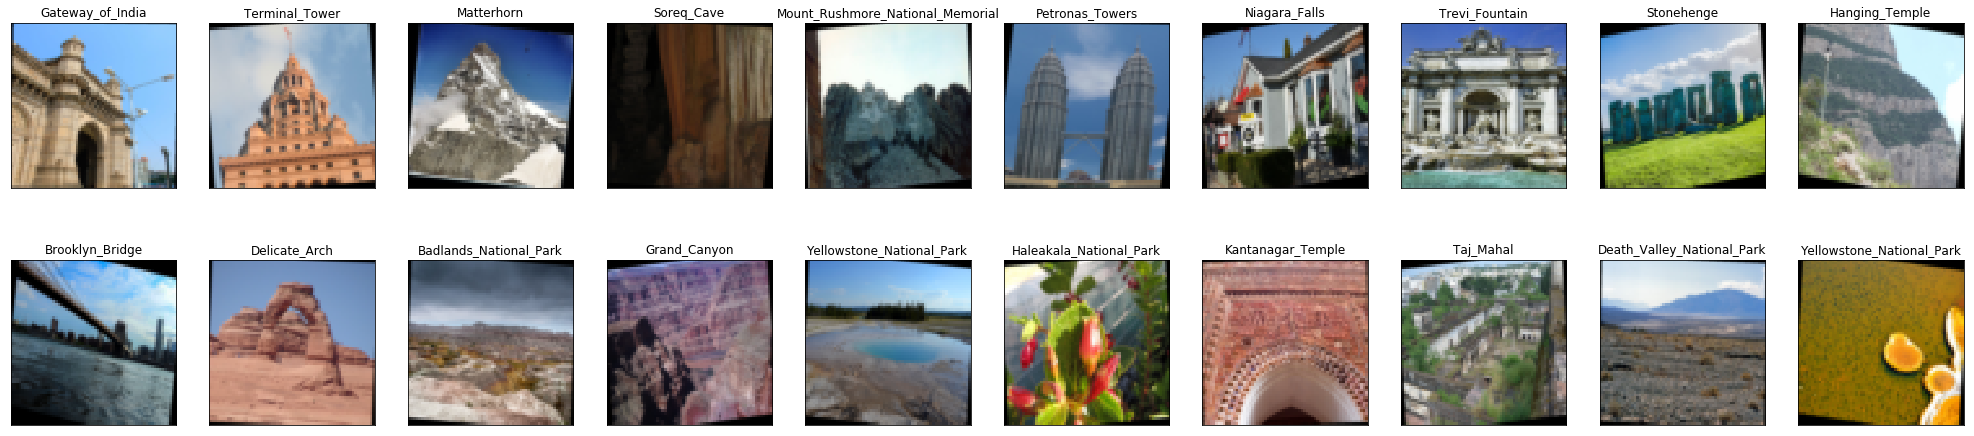

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

#visualize a batch of the train data loader
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
    
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)


dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() #convert images to numpy for display

fig = plt.figure(figsize=(35, 8))

#display images in a batch, along with the corresponding labels
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
    
    

### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  

In [4]:
#select loss function
criterion_scratch = torch.nn.CrossEntropyLoss()


def get_optimizer_scratch(model):
    # select and return an optimizer
    return torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    

###  Model Architecture

Create a CNN to classify images of landmarks. 

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    # choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = 16
        self.layer2 = 32
        self.layer3 = 64
        self.layer4 = 128
        
        self.mlp_layer1 = 1000
        self.mlp_layer2 = 250
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, self.layer1, 3, padding = 1)
        self.conv2 = nn.Conv2d(self.layer1, self.layer2, 3, padding = 1)
        self.conv3 = nn.Conv2d(self.layer2, self.layer3, 3, padding = 1)
        self.conv4 = nn.Conv2d(self.layer3, self.layer4, 3, padding = 1)
        self.pool = nn.MaxPool2d(2,2)
        
        
        ## Define layers of a MLP
        self.fc1 = nn.Linear(int(self.layer4 * 4 * 4), self.mlp_layer1)
        self.fc2 = nn.Linear(self.mlp_layer1 , self.mlp_layer2)
        self.fc3 = nn.Linear(self.mlp_layer2 , 50)
        self.dropout = nn.Dropout(p = 0.2)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x.view(-1, int(self.layer4 * 4 * 4)))
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
                
        return x
    

# instantiate the CNN
model_scratch = Net()
print(model_scratch)
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=50, bias=True)
  (dropout): Dropout(p=0.2)
)


  
I chose 4 convolutional layers and 3 linear layers for my final CNN architecture. I also used max pool layers after each convolutioanal layers to decrease the number of parameters and used dropout layers between linear layers (but  the last layer) to prevent overfitting. As an activation function for all the layers (but the last layer), I used ReLu. For the convolutional layers, I started with the depth of 16, and for next layers I multiplied it by 2. 

###  Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [12]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            # clear the gradients of all optimized variables 
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            #backward pass: compute gradient of the loss with respect to the model parameters
            loss.backward()
            
            #perform a single optimization step (parameter update)
            optimizer.step()
            
            #update training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # update average validation loss
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
                        
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased. Saving...')

        
        
    return model

### Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [13]:
def custom_weight_init(m):
    ## implement a weight initialization strategy
    classname = m.__class__.__name__
    #for every linear layer in a model ...
    if classname.find('Linear') != -1:
        #get the number of the inouts
        n = m.in_features
        y = 1/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
    
    
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.879628 	Validation Loss: 3.785004
Validation loss decreased. Saving...
Epoch: 2 	Training Loss: 3.711528 	Validation Loss: 3.656456
Validation loss decreased. Saving...
Epoch: 3 	Training Loss: 3.579913 	Validation Loss: 3.498424
Validation loss decreased. Saving...
Epoch: 4 	Training Loss: 3.433056 	Validation Loss: 3.383493
Validation loss decreased. Saving...
Epoch: 5 	Training Loss: 3.306233 	Validation Loss: 3.331627
Validation loss decreased. Saving...
Epoch: 6 	Training Loss: 3.167658 	Validation Loss: 3.217426
Validation loss decreased. Saving...
Epoch: 7 	Training Loss: 3.031090 	Validation Loss: 3.117352
Validation loss decreased. Saving...
Epoch: 8 	Training Loss: 2.892350 	Validation Loss: 3.121596
Epoch: 9 	Training Loss: 2.780048 	Validation Loss: 2.967120
Validation loss decreased. Saving...
Epoch: 10 	Training Loss: 2.671445 	Validation Loss: 2.923842
Validation loss decreased. Saving...
Epoch: 11 	Training Loss: 2.536292 	Validation Loss: 2.8

### Train and Validate the Model

Run the next code cell to train your model.

In [14]:
## you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 30 # Ran it with 100 once but the results did not improve after epoch 16


# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.859662 	Validation Loss: 3.795663
Validation loss decreased. Saving...
Epoch: 2 	Training Loss: 3.744924 	Validation Loss: 3.699526
Validation loss decreased. Saving...
Epoch: 3 	Training Loss: 3.625427 	Validation Loss: 3.571468
Validation loss decreased. Saving...
Epoch: 4 	Training Loss: 3.468170 	Validation Loss: 3.483221
Validation loss decreased. Saving...
Epoch: 5 	Training Loss: 3.342685 	Validation Loss: 3.370133
Validation loss decreased. Saving...
Epoch: 6 	Training Loss: 3.221907 	Validation Loss: 3.269220
Validation loss decreased. Saving...
Epoch: 7 	Training Loss: 3.123799 	Validation Loss: 3.201701
Validation loss decreased. Saving...
Epoch: 8 	Training Loss: 3.026509 	Validation Loss: 3.115474
Validation loss decreased. Saving...
Epoch: 9 	Training Loss: 2.898269 	Validation Loss: 3.074934
Validation loss decreased. Saving...
Epoch: 10 	Training Loss: 2.808512 	Validation Loss: 3.022115
Validation loss decreased. Saving...
Epoch: 11 	Training

### Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [15]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.741274


Test Accuracy: 33% (418/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.


In [1]:
## Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
## Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import numpy as np
import torch

from torchvision import datasets 
import torchvision.transforms as transforms 
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load 
batch_size = 20

# percentage of training set to use as validation
valid_size = 0.2

img_size = 224

# convert data to a normalized torch.FloatTensor
transform = {'train' : transforms.Compose([
            transforms.RandomHorizontalFlip(), # randomly flip and rotate
            transforms.RandomRotation(10),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), 
            'test': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}



# choose the training and test datasets
train_data = datasets.ImageFolder('/data/landmark_images/train/', transform = transform['train'])
test_data = datasets.ImageFolder('/data/landmark_images/test/', transform = transform['test'])

#obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

#define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


#prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                           num_workers = num_workers)


loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

# specify the image classes
classes = [x.split('.')[1] for x in train_data.classes]




### Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  

In [2]:
## select loss function
criterion_transfer = torch.nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## select and return an optimizer
    return torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  

In [7]:
## Specify model architecture
from torchvision import models 

vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False
    

vgg16.classifier[6] = torch.nn.Linear(4096, 50)
    
    
model_transfer = vgg16



if use_cuda:
    model_transfer = model_transfer.cuda()


I used Vgg16 for this problem and I just changed the last layer to fit the number of classes in this problem (which is 50). I fixed all the parameters in the covolutional parts so they won't be trained again. Theis architecture is suitable for the current problem as I searched the web and found out that Vgg16 is suitable for landmark detection (although this dataset is a different from the one that Vgg16 was trained on, it is still capable of detecting the patterns).

###  Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [9]:
# train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 40

model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')


# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.174874 	Validation Loss: 2.182943
Validation loss decreased. Saving...
Epoch: 2 	Training Loss: 2.630780 	Validation Loss: 1.912524
Validation loss decreased. Saving...
Epoch: 3 	Training Loss: 2.561097 	Validation Loss: 1.908781
Validation loss decreased. Saving...
Epoch: 4 	Training Loss: 2.471020 	Validation Loss: 1.922527
Epoch: 5 	Training Loss: 2.248049 	Validation Loss: 1.840923
Validation loss decreased. Saving...
Epoch: 6 	Training Loss: 2.058592 	Validation Loss: 1.800336
Validation loss decreased. Saving...
Epoch: 7 	Training Loss: 2.149971 	Validation Loss: 1.810547
Epoch: 8 	Training Loss: 2.007919 	Validation Loss: 1.735592
Validation loss decreased. Saving...
Epoch: 9 	Training Loss: 1.841653 	Validation Loss: 1.751674
Epoch: 10 	Training Loss: 1.945611 	Validation Loss: 1.794350
Epoch: 11 	Training Loss: 1.911326 	Validation Loss: 1.854050
Epoch: 12 	Training Loss: 1.780229 	Validation Loss: 1.882977
Epoch: 13 	Training Loss: 1.738554 	Validat

### Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.

In [8]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.622053


Test Accuracy: 64% (809/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Let's define some functions to make it easy for others to use our classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [42]:
import cv2
from PIL import Image
from copy import deepcopy

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

loader = transform['test']

def predict_landmarks(img_path, k):
    ## return the names of the top k landmarks predicted by the transfer learned CNN
    # model_best = deepcopy(model_transfer.load_state_dict(torch.load('model_transfer.pt')))
    
    image = Image.open(img_path)
    image = loader(image).float()
    data = image.unsqueeze(0)
    
    if use_cuda:
            data = data.cuda()
    output = model_transfer(data)
    _, pred = torch.topk(output,k,dim=1)
    
    pred = pred.cpu().numpy()[0]
    
    toprint = [classes[x] for x in pred]
    
    return toprint
    

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Forth_Bridge',
 'Golden_Gate_Bridge',
 'Brooklyn_Bridge',
 'Sydney_Harbour_Bridge',
 'Sydney_Opera_House']

### Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this picture of the Forth_Bridge, Golden_Gate_Bridge, or Brooklyn_Bridge?


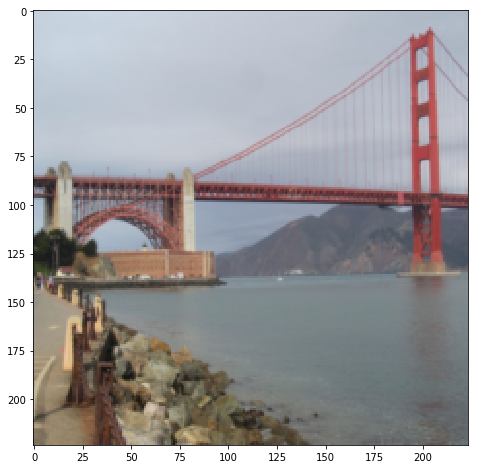

In [43]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    image = Image.open(img_path)
    image = loader(image).numpy()
    ## display image and display landmark predictions
    fig = plt.figure(figsize=(35, 8))
    imshow(image)
    
    print("Is this picture of the {}, {}, or {}?".format(predicted_landmarks[0], predicted_landmarks[1], predicted_landmarks[2]))
    #print(predicted_landmarks)
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.


Is this picture of the Brooklyn_Bridge, Sydney_Harbour_Bridge, or Niagara_Falls?
Is this picture of the Taj_Mahal, Edinburgh_Castle, or Ljubljana_Castle?
Is this picture of the Sydney_Opera_House, Sydney_Harbour_Bridge, or Washington_Monument?
Is this picture of the Seattle_Japanese_Garden, Central_Park, or Machu_Picchu?


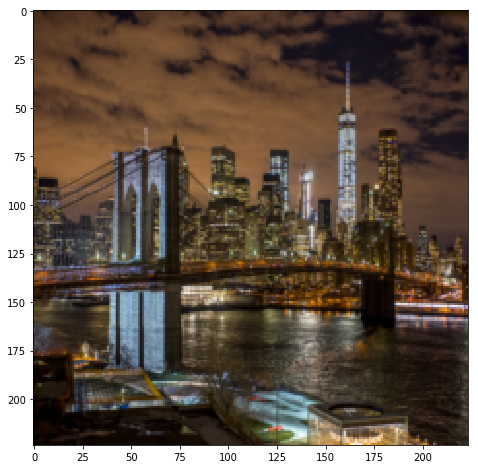

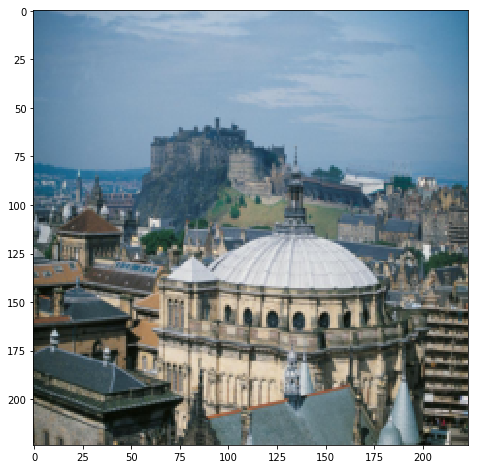

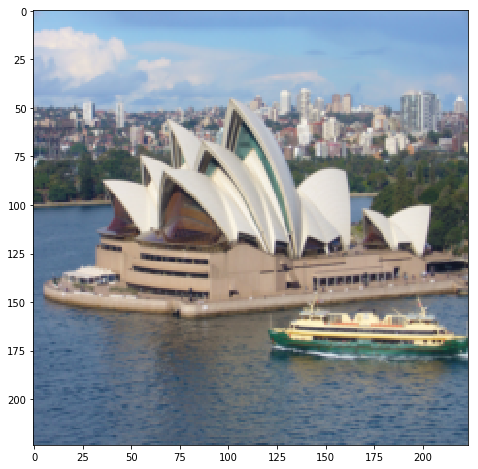

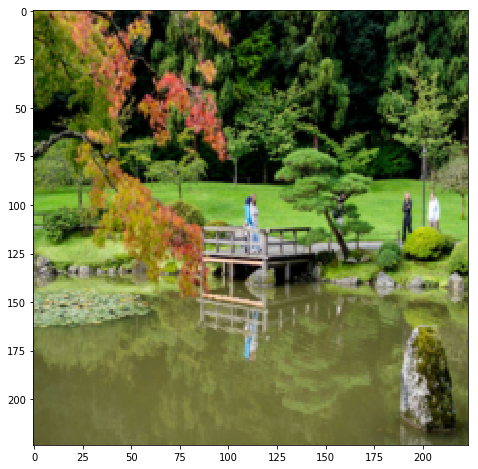

In [50]:
## Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

import os
from os import listdir
from os.path import isfile, join

mypath = os.path.join(os.getcwd(), 'Myimages')

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for file in onlyfiles:
    img_path = os.path.join(mypath, file)
    suggest_locations(img_path)
